# P60 Gitterschwingungen in Festkörpern

### Import libaries

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from matplotlib.colors import TABLEAU_COLORS, same_color
from scipy.optimize import curve_fit
from scipy.stats import linregress
from numpy import sqrt


%matplotlib inline

### Set sytle parameters

In [ ]:
#plt.style.available[:30]

plt.style.use('default')
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'


### Get and set colors

In [ ]:
# Get the color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print(colors)


### Define Lorentzians and FWHM functions

In [ ]:
# Lorentz function
def lorentzian(x, x0, gamma, a, y0):
    return a * gamma**2 / ((x - x0)**2 + gamma**2) + y0

# Calculate Full Width at Half Maximum (FWHM) for Lorentzian
def lorentzian_fwhm(gamma):
    return 2 * gamma

# double Lorentzian function
def double_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2 , y0):
    L1 = (a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2)))
    L2 = (a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2)))
    return L1 + L2 + y0

# sum of 3 lorentzians
def three_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2, x03, gamma3, a3, y0):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    L3 = a3 * (gamma3**2 / ((x - x03)**2 + gamma3**2))
    return L1 + L2 + L3 + y0


# sum of 4 lorentzians
def four_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2, x03, gamma3, a3, x04, gamma4, a4, y0):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    L3 = a3 * (gamma3**2 / ((x - x03)**2 + gamma3**2))
    L4 = a4 * (gamma4**2 / ((x - x04)**2 + gamma4**2))
    return L1 + L2 + L3 + L4 + y0


# sum of 5 lorentzians
def five_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2, x03, gamma3, a3, x04, gamma4, a4, x05, gamma5, a5, y0):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    L3 = a3 * (gamma3**2 / ((x - x03)**2 + gamma3**2))
    L4 = a4 * (gamma4**2 / ((x - x04)**2 + gamma4**2))
    L5 = a5 * (gamma5**2 / ((x - x05)**2 + gamma5**2))
    return L1 + L2 + L3 + L4 + L5 + y0


# Fitting Lorentzian to data in specific range
def n_lorentzians_fit (df, function, xmin, xmax, p0):
    df_region = (df['Wavenumber'] > xmin) & (df['Wavenumber'] < xmax)
    xdata = df['Wavenumber'][df_region]
    ydata = df['Intensity'][df_region]
    params, cov = curve_fit(function, xdata, ydata, p0)
    perr = np.sqrt(np.diag(cov))

    return xdata, params, perr


# Fitting Lorentzian to data in specific range shifted
def n_lorentzians_fit_shifted (df, function, xmin, xmax, p0):
    df_region = (df['Wavenumber_shifted'] > xmin) & (df['Wavenumber_shifted'] < xmax)
    xdata = df['Wavenumber_shifted'][df_region]
    ydata = df['Intensity'][df_region]
    params, cov = curve_fit(function, xdata, ydata, p0)
    perr = np.sqrt(np.diag(cov))

    return xdata, params, perr

### Import data Si (100)

In [ ]:
file_path_si100_parallel = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\si100 polarisation 0grad\\'
file_path_si100_perpendicular = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\si100 polarisation 90grad\\'


file_names = ['si100_0grad.txt', 'si100_15grad.txt', 'si100_30grad.txt', 'si100_45grad.txt', 
              'si100_60grad.txt', 'si100_75grad.txt', 'si100_90grad.txt',
              'si100_105grad.txt', 'si100_120grad.txt', 'si100_135grad.txt', 
              'si100_150grad.txt', 'si100_165grad.txt', 'si100_180grad.txt']

dataframes_si100_parallel = []
dataframes_si100_perpendicular = []


for file in file_names:
    df = pd.read_csv(file_path_si100_parallel + file, sep=r'\s+', names=['Wavenumber', 'Intensity'])
    dataframes_si100_parallel.append(df)

    
for file in file_names:
    df = pd.read_csv(file_path_si100_perpendicular + file, sep=r'\s+', names=['Wavenumber', 'Intensity'])
    dataframes_si100_perpendicular.append(df)


#dataframes_si100_perpendicular[0].head()

### Importing data Si (111)

In [ ]:
file_path_si111 = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\si111\\'

df_si111_parallel = pd.read_csv(file_path_si111 + 'si111_0grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber', 'Intensity'])
df_si111_perpendicular = pd.read_csv(file_path_si111 + 'si111_90grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber', 'Intensity'])


### Calculating Wavenumber shift and apply to data and Wavenumber error

In [ ]:
# Calculating Wavenumber shift by fitting lorentzian to Rayleigh-Peaks of Si (100) and Si (111)

rayleigh_x0 = []
rayleigh_gamma = []

# Si (100) parallel
for i in range(13):
    _, params, _ = n_lorentzians_fit(dataframes_si100_parallel[i], lorentzian, -20, 15, p0=None)
    rayleigh_x0.append(params[0])
    rayleigh_gamma.append(lorentzian_fwhm(params[1]))

# Si (100) perpendicular
for i in range(13):
    _, params, _ = n_lorentzians_fit(dataframes_si100_perpendicular[i], lorentzian, -20, 15, p0=None)
    rayleigh_x0.append(params[0])
    rayleigh_gamma.append(lorentzian_fwhm(params[1]))


# Si (111) parallel and perpendicular
_, params_si111_par, _ =n_lorentzians_fit(df_si111_parallel, lorentzian, -20, 15, p0=None)
_, params_si111_per, _ =n_lorentzians_fit(df_si111_perpendicular, lorentzian, -20, 15, p0=None)

rayleigh_x0.append(params_si111_par[0])
rayleigh_x0.append(params_si111_per[0])
rayleigh_gamma.append(lorentzian_fwhm(params_si111_par[1]))
rayleigh_gamma.append(lorentzian_fwhm(params_si111_par[1]))

# calculate wavenumber shift
wavenumber_shift = np.mean(rayleigh_x0)
print(wavenumber_shift)


# calculate wavenumber error with fwhm of rayleigh peak
ray_gamma_series = pd.Series(rayleigh_gamma)
wavenumber_error = np.sqrt((ray_gamma_series**2).sum()) / (ray_gamma_series.count())
print(wavenumber_error)



for i in range(13):
    dataframes_si100_parallel[i]['Wavenumber_shifted'] = dataframes_si100_parallel[i]['Wavenumber'] - wavenumber_shift
    dataframes_si100_perpendicular[i]['Wavenumber_shifted'] = dataframes_si100_perpendicular[i]['Wavenumber'] - wavenumber_shift




# Si (100) determine x- and y-axis

### Fitting Anti-Stokes and Normalize Intensities of Si (100) parallel

In [ ]:
Lorentzian_amplitudes = []
Lorentzian_amplitudes_error = []

for i in range(13):

    # Region and amplitude for inital fit
    antistokes_peak_region = (dataframes_si100_parallel[i]['Wavenumber_shifted'] > 500) & (dataframes_si100_parallel[i]['Wavenumber_shifted'] < 540)
    antistokes_amplitude = dataframes_si100_parallel[i]['Intensity'][antistokes_peak_region].max()
    background = dataframes_si100_parallel[i]['Intensity'][antistokes_peak_region].min()

    # Initial guess [center, width, amplitude]
    p0_antistokes = [521, 5 , antistokes_amplitude, background]

    # Fit with lorentzian
    x_data = dataframes_si100_parallel[i]['Wavenumber_shifted'][antistokes_peak_region]
    y_data = dataframes_si100_parallel[i]['Intensity'][antistokes_peak_region]
    params, cov = curve_fit(lorentzian, x_data, y_data, p0=p0_antistokes)

    # Amplitude and Error of lorentzian fit
    cov_err = np.sqrt(np.diag(cov))
    Lorentzian_amplitudes.append(params[2]+cov_err[2]) # amplitude+error to stay between 0-1 with errors
    Lorentzian_amplitudes_error.append(cov_err[2])



# Normilize Intensities, Amplitude fitted with lorentzian
norm = max(Lorentzian_amplitudes)
Lorentzian_amplitudes_normilized = Lorentzian_amplitudes/norm
Lorentzian_amplitudes_normilized_error = Lorentzian_amplitudes_error/norm


print(Lorentzian_amplitudes_error)


### Fitting Anti-Stokes and Normalize Intensities of Si (100) perpendicular

In [ ]:
Lorentzian_amplitudes_per = []
Lorentzian_amplitudes_per_error = []

for i in range(13):

    # Region and amplitude for inital fit
    antistokes_peak_region_per = (dataframes_si100_perpendicular[i]['Wavenumber_shifted'] > 500) & (dataframes_si100_perpendicular[i]['Wavenumber_shifted'] < 540)
    antistokes_amplitude_per = dataframes_si100_perpendicular[i]['Intensity'][antistokes_peak_region_per].max()
    background = dataframes_si100_perpendicular[i]['Intensity'][antistokes_peak_region_per].min()

    # Initial guess [center, width, amplitude]
    p0_antistokes = [521, 10 , antistokes_amplitude_per, background]

    # Fit with lorentzian
    x_data = dataframes_si100_perpendicular[i]['Wavenumber_shifted'][antistokes_peak_region_per]
    y_data = dataframes_si100_perpendicular[i]['Intensity'][antistokes_peak_region_per]
    params, cov = curve_fit(lorentzian, x_data, y_data, p0=p0_antistokes)

    # Amplitude and error of lorentzian fit
    cov_per_error = np.sqrt(np.diag(cov))
    Lorentzian_amplitudes_per.append(params[2] + cov_per_error[2])
    Lorentzian_amplitudes_per_error.append(cov_per_error[2])


# Normilize Intensities, Amplitude fitted with lorentzian
del Lorentzian_amplitudes_per[1] #remove intensity at 15°
del Lorentzian_amplitudes_per_error[1] # remove error at 15°

norm_per = max(Lorentzian_amplitudes_per)
Lorentzian_amplitudes_normilized_per = Lorentzian_amplitudes_per/norm_per
Lorentzian_amplitudes_normilized_per_error = Lorentzian_amplitudes_per_error/norm_per


print(Lorentzian_amplitudes_per_error)

### Plotting the data of Si (100) parallel

In [ ]:
# Visualize Si (100) parallel data
%matplotlib widget


# define linespace for better fit visualization
antistokes_linespace = np.linspace(500, 550, 300)

# 0° shift Peak
xdata_si100_0, params_si100_0, params_si100_0_error = n_lorentzians_fit_shifted(dataframes_si100_parallel[0], lorentzian,
500, 540, p0=None)


# 30° shift Peak
xdata_si100_30, params_si100_30, params_si100_30_error = n_lorentzians_fit_shifted(dataframes_si100_parallel[1], lorentzian,
500, 540, p0=None)


# 60° shift Peak
xdata_si100_60, params_si100_60, params_si100_60_error = n_lorentzians_fit_shifted(dataframes_si100_parallel[2], lorentzian,
500, 540, p0=None)


# 90° shift Peak
xdata_si100_90, params_si100_90, params_si100_90_error = n_lorentzians_fit_shifted(dataframes_si100_parallel[3], lorentzian,
500, 540, p0=None)




# Plot figure
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

# 0°
ax.errorbar(dataframes_si100_parallel[0]['Wavenumber_shifted'], dataframes_si100_parallel[0]['Intensity'],
             label = r'$\mathit{I}_{\parallel, Si(100), 0°}$', fmt='o', ms=3, c=colors[0])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_0), c=colors[0], alpha=0.7)
ax.errorbar(params_si100_0[0], params_si100_0[2], yerr=params_si100_0_error[2], c=colors[0], capsize=3, alpha=0.7)

# 30°
ax.errorbar(dataframes_si100_parallel[1]['Wavenumber_shifted'], dataframes_si100_parallel[1]['Intensity'],
             label = r'$\mathit{I}_{\parallel, Si(100), 30°}$', fmt='o', ms=3, c=colors[1])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_30), c=colors[1], alpha=0.7)
ax.errorbar(params_si100_30[0], params_si100_30[2], yerr=params_si100_30_error[2], c=colors[1], capsize=3, alpha=0.7)


# 60°
ax.errorbar(dataframes_si100_parallel[2]['Wavenumber_shifted'], dataframes_si100_parallel[2]['Intensity'],
             label = r'$\mathit{I}_{\parallel, Si(100), 60°}$', fmt='o', ms=3, c=colors[2],)
# ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_60), c=colors[2])

ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_60), c=colors[2], alpha=0.7)
ax.errorbar(params_si100_60[0], params_si100_60[2], yerr=params_si100_60_error[2], c=colors[2], capsize=3, alpha=0.7)


# 90°
ax.errorbar(dataframes_si100_parallel[3]['Wavenumber_shifted'], dataframes_si100_parallel[3]['Intensity'],
             label = r'$\mathit{I}_{\parallel, Si(100), 90°}$', fmt='o', ms=3, c=colors[3])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_90), c=colors[3], alpha=0.7)
ax.errorbar(params_si100_90[0], params_si100_90[2], yerr=params_si100_90_error[2], c=colors[3], capsize=3, alpha=0.7)




ax.set_xlabel(r'Wellenzahlverschiebung ($cm^{-1}$)', fontsize = 14)
ax.set_ylabel('Intensität (arb. u.)', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlim(500,545)
ax.legend(fontsize=16)

fig.savefig(r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Bilder\si100_intensity_vs_wavenumber_parallel.pdf', dpi=300)

#print(params_si100_0_error[2], params_si100_30_error[2], params_si100_60_error[2], params_si100_90_error[2])

### Plotting the data of Si (100) perpendicular

In [ ]:
# Visualize Si (100) perpendicular data
%matplotlib widget


# Define linespace for better fit visualization
antistokes_linespace = np.linspace(500, 550, 200)


# Fitting Peaks
# 0° shift Peak
xdata_si100_per_0, params_si100_per_0, params_si100_per_0_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[0], lorentzian,
500, 540, p0=None)


# 30° shift Peak
xdata_si100_per_30, params_si100_per_30, params_si100_per_30_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[1], lorentzian,
500, 540, p0=None)


# 60° shift Peak
xdata_si100_per_60, params_si100_per_60, params_si100_per_60_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[2], lorentzian,
500, 540, p0=None)


# 90° shift Peak
xdata_si100_per_90, params_si100_per_90, params_si100_per_90_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[3], lorentzian,
500, 540, p0=None)


# 120° shift Peak
xdata_si100_per_120, params_si100_per_120, params_si100_per_120_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[4], lorentzian,
500, 540, p0=None)

# 150° shift Peak
xdata_si100_per_150, params_si100_per_150, params_si100_per_150_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[5], lorentzian,
500, 540, p0=[522, 5, 900, 0])


# 180° shift Peak
xdata_si100_per_180, params_si100_per_180, params_si100_per_180_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[6], lorentzian,
500, 540, p0=None)




# Plot figure
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

# 0°
ax.errorbar(dataframes_si100_perpendicular[0]['Wavenumber_shifted'], dataframes_si100_perpendicular[0]['Intensity'],
             label = r'$\mathit{I}_{\perp, Si(100), 0°}$', fmt='o', ms=3, c=colors[0])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_0), c=colors[0], alpha=0.7)
ax.errorbar(params_si100_per_0[0], params_si100_per_0[2], yerr=params_si100_per_0_error[2], c=colors[0], capsize=3, alpha=0.7)

# 30°
ax.errorbar(dataframes_si100_perpendicular[1]['Wavenumber_shifted'], dataframes_si100_perpendicular[1]['Intensity'],
             label = r'$\mathit{I}_{\perp, Si(100), 30°}$', fmt='o', ms=3, c=colors[1])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_30), c=colors[1], alpha=0.7)
ax.errorbar(params_si100_per_30[0], params_si100_per_30[2], yerr=params_si100_per_30_error[2], c=colors[1], capsize=3, alpha=0.7)


# 60°
ax.errorbar(dataframes_si100_perpendicular[2]['Wavenumber_shifted'], dataframes_si100_perpendicular[2]['Intensity'],
             label = r'$\mathit{I}_{\perp, Si(100), 60°}$', fmt='o', ms=3, c=colors[2])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_60), c=colors[2], alpha=0.7)
ax.errorbar(params_si100_per_60[0], params_si100_per_60[2], yerr=params_si100_per_60_error[2], c=colors[2], capsize=3, alpha=0.7)


# 90°
ax.errorbar(dataframes_si100_perpendicular[3]['Wavenumber_shifted'], dataframes_si100_perpendicular[3]['Intensity'],
             label = r'$\mathit{I}_{\perp, Si(100), 90°}$', fmt='o', ms=3, c=colors[3])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_90), c=colors[3], alpha=0.7)
ax.errorbar(params_si100_per_90[0], params_si100_per_90[2], yerr=params_si100_per_90_error[2], c=colors[3], capsize=3, alpha=0.7)


# 120°
ax.errorbar(dataframes_si100_perpendicular[4]['Wavenumber_shifted'], dataframes_si100_perpendicular[4]['Intensity'],
             label = r'$\mathit{I}_{\perp, Si(100), 120°}$', fmt='o', ms=3, c=colors[4])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_120), c=colors[4], alpha=0.7)
ax.errorbar(params_si100_per_120[0], params_si100_per_120[2], yerr=params_si100_per_120_error[2], c=colors[4], capsize=3, alpha=0.7)

# 150°
ax.errorbar(dataframes_si100_perpendicular[5]['Wavenumber_shifted'], dataframes_si100_perpendicular[5]['Intensity'],
             label = r'$\mathit{I}_{\perp, Si(100), 150°}$', fmt='o', ms=3, c=colors[5])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_150), c=colors[5], alpha=0.7)
ax.errorbar(params_si100_per_150[0], params_si100_per_150[2], yerr=params_si100_per_150_error[2], c=colors[5], capsize=3, alpha=0.7)

# 180°
ax.errorbar(dataframes_si100_perpendicular[6]['Wavenumber_shifted'], dataframes_si100_perpendicular[6]['Intensity'],
             label = r'$\mathit{I}_{\perp, Si(100), 180°}$', fmt='o', ms=3, c=colors[6])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_180), c=colors[6], alpha=0.7)
ax.errorbar(params_si100_per_180[0], params_si100_per_180[2], yerr=params_si100_per_180_error[2], c=colors[6], capsize=3, alpha=0.7)




ax.set_xlabel(r'Wellenzahlverschiebung ($cm^{-1}$)', fontsize = 14)
ax.set_ylabel('Intensität (arb. u.)', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlim(500,545)
ax.legend(fontsize=14)



fig.savefig(r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Bilder\si100_intensity_wavenumber_perpendicular.pdf', dpi=300)

# print(params_si100_per_0_error[2], params_si100_per_30_error[2], params_si100_per_60_error[2], params_si100_per_90_error[2], params_si100_per_120_error[2])



### Create new DataFrame to plot Intensity vs Degree Si (100)

In [ ]:
%matplotlib widget

# List of radians 0 to 360 degrees in 30 degree steps
degrees = [i for i in range(0, 361, 30)]
degrees_wo_15 = [i for i in range(0, 361, 30)]
del degrees_wo_15[1] # remove 15 degree index

# create dataframe for si (100) parallel
data = {'Degree' : degrees, 'Intensity': Lorentzian_amplitudes_normilized, 'Intensity_error': Lorentzian_amplitudes_normilized_error}
df_si100_norm_parallel = pd.DataFrame(data)
#df_si100_norm_parallel = df_si100_norm_parallel.iloc[:-1] #omit last Intensity at 360 degrees



# calculate error assuming that intensity every 45° should be the same
temp0 = []
for i in range(0, 10, 3):
    temp0.append(df_si100_norm_parallel['Intensity'].iloc[i])

error0 = np.max(temp0) - np.min(temp0)


temp1 = []
for i in range(1, 11, 3):
    temp1.append(df_si100_norm_parallel['Intensity'].iloc[i])

error1 = np.max(temp1) - np.min(temp1)


temp2 = []
for i in range(2, 12, 3):
    temp2.append(df_si100_norm_parallel['Intensity'].iloc[i])

error2 = np.max(temp2) - np.min(temp2)



# create dataframe for si (100) parallel
data_per = {'Degree' : degrees_wo_15, 'Intensity': Lorentzian_amplitudes_normilized_per, 
            'Intensity_error': Lorentzian_amplitudes_normilized_per_error}
df_si100_norm_perpendicular = pd.DataFrame(data_per)




# error calculation for si (100) perpendicular
error_si100_per =  df_si100_norm_perpendicular['Intensity'].iloc[8] - df_si100_norm_perpendicular['Intensity'].iloc[0]



# Plot data
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.errorbar(df_si100_norm_parallel['Degree'], df_si100_norm_parallel['Intensity'], fmt='o', 
            yerr=df_si100_norm_parallel['Intensity_error'], ls='-', ms=3)
ax.errorbar(df_si100_norm_perpendicular['Degree'], df_si100_norm_perpendicular['Intensity'], fmt='o', 
            yerr=df_si100_norm_perpendicular['Intensity_error'], ls='-', ms=3)
ax.set_xlabel('Winkel (°)')
ax.set_ylabel('normierte Intensität')



### Define sin^2(2x) and cos^2(2x) functions

In [ ]:
# Define sin^2(2x) function x, amplitude, xshift ,yshift = amplitude, degree (in Radians), degree shift, vertical shift
def sin_squared(x, amplitude, xshift, yshift):
    return amplitude * np.sin((np.pi/90)*(x + xshift))**2 + yshift


# Define cos^2(2x) function x, amplitude, xshift ,yshift = amplitude, degree (in Radians), degree shift, vertical shift
def cos_squared(x, amplitude, xshift, yshift):
    return amplitude * np.cos((np.pi/90)*(x + xshift))**2 + yshift



### Fitting sin^2(2x) to Si (100)

In [ ]:
# fitting sin^2(2x)
xdata = df_si100_norm_parallel['Degree']
ydata = df_si100_norm_parallel['Intensity']

popt, pcov = curve_fit(sin_squared, xdata, ydata)
perr = np.sqrt(np.diag(pcov))
print(f'Fit parameters for sin^2(2x): amplitude = {popt[0]:.2f}  +- {perr[0]:.2f}, xshift = {popt[1]:.2f} +- {perr[1]:.2f}, yshift = {popt[2]:.2f}  +- {perr[2]:.2f}' + f', xshift+90° = {popt[1] + 90:.2f}')





# Plotting data
deg_range = np.arange(0, 361, 1)
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.errorbar(df_si100_norm_parallel['Degree'], df_si100_norm_parallel['Intensity'],
            fmt='o', xerr=1, yerr=df_si100_norm_parallel['Intensity_error'], ls='', ms=4,
            label = r'$\mathit{I}_{\parallel, Si(100)}$'
            )



ax.plot(deg_range, sin_squared(deg_range, *popt), label = 'Fit: ' r'$1.0(1) \cdot \sin^2(\frac{\pi}{90°}(\Phi + 66(1)°)) + 0.05(6)$')


ax.set_xlabel(r'Winkel $\Phi$ (°)', fontsize=18)
ax.set_ylabel('normierte Intensität', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xticks([i for i in range(0, 361, 30)])
ax.set_xlim(-20, 380)
ax.set_ylim(-0.05,1.25)
ax.legend(fontsize=12, loc=2, ncol=2) #loc 2 = upper left


fig.savefig(r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Bilder\si100_sin_fit_parallel.pdf', dpi=300)


### Fitting cos^2(2x) so Si (100)

In [ ]:
# Fitting cos^2(2x)
xdata = df_si100_norm_perpendicular['Degree']
ydata = df_si100_norm_perpendicular['Intensity']

popt, pcov = curve_fit(cos_squared, xdata, ydata)
perr = np.sqrt(np.diag(pcov))
print(f'Fit parameters for cos^2(2x)_v2: amplitude = {popt[0]:.2f}  +- {perr[0]:.2f}, xshift = {popt[1]:.2f} +- {perr[1]:.2f}, yshift = {popt[2]:.2f}  +- {perr[2]:.2f}' + f', xshift+90° = {popt[1] + 90:.2f}')



# Plotting data
deg_range = np.arange(0, 361, 1)
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)


ax.errorbar(df_si100_norm_perpendicular['Degree'], df_si100_norm_perpendicular['Intensity']
            , fmt='o', xerr=1, yerr=df_si100_norm_perpendicular['Intensity_error'], ls='', ms=5, alpha=1, errorevery = 1
            , label = r'$\mathit{I}_{\perp, Si(100)}$'
            )


ax.plot(deg_range, cos_squared(deg_range, *popt), label = 'Fit: ' r'$1.03(13) \cdot \cos^2(\frac{\pi}{90°}(\Phi + 68(2)°)) + 0.03(8)$')

ax.set_xlabel(r'Winkel $\Phi$ (°)', fontsize=18)
ax.set_ylabel('normierte Intensität', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)


ax.set_xticks([i for i in range(0, 361, 30)])
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_ylim(-0.05, 1.25)
ax.set_xlim(-20, 380)
ax.legend(fontsize=12, loc=2, ncol=2) #loc=1 -> upper right

fig.savefig(r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Bilder\si100_cos_fit_senkrecht.pdf', dpi=300)



# Uncertainty reminder

two values with errors
- $x_1 \pm \sigma_1$
- $x_2 \pm \sigma_2$

mean

- $\bar{x}=\frac{x_1 + x_2}{2}$


uncertainty with error propagation

- $\sigma_\text{mean} = \frac{1}{2} \sqrt{\sigma_1^2 + \sigma_2^2}$

In [ ]:
# Error Propagation function

def sum_of_errors(sigmas):
    sigma_series = pd.Series(sigmas)
    return np.sqrt((sigma_series**2).sum())


# Si (111)

### Plot Si (111)

Fit Lorentzian to Rayleigh Peak to calculate the wavenumber shift 

- Si (111) parallel $\rightarrow$ params_ray[0]
- Si (111) perpendicular $\rightarrow$ params_ray_per[0]

Anti-Stokes Peak x0 = 521.37 +- 0.06 Si (111) parallel
Anti-Stokes Peak x0 = 521.70 +- 0.07 Si (111) senkrecht
Small Peak x0 = 303.31 +- 0.12


C:\Users\duong\AppData\Local\Temp\ipykernel_12760\209840455.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)


(-30.0, 1050.0)

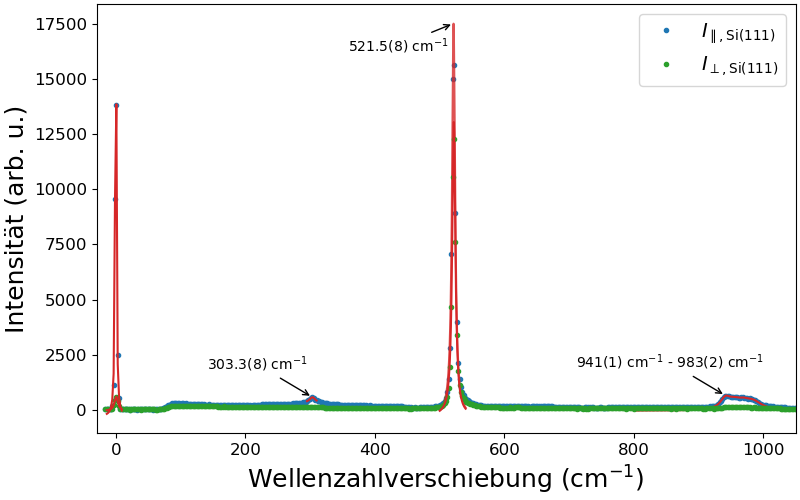

In [451]:
# Visualizing Si (111) data
%matplotlib widget


# Define linespace for better lorentzian fit
x = np.linspace(-20, 1200, 2000)
x_as_peak = np.linspace(500, 540, 200)
x_900_1100 = np.linspace(800, 1100, 600)



# Shift Wavenumber of Si (111) parallel and perpendicular
df_si111_parallel['Wavenumber_shifted'] = df_si111_parallel['Wavenumber'] - wavenumber_shift
df_si111_perpendicular['Wavenumber_shifted'] = df_si111_perpendicular['Wavenumber'] - wavenumber_shift



# Fitting Peaks

# Fit Rayleigh Peaks
xdata_si111_par_ray, params_si111_par_ray, params_si111_par_ray_error = n_lorentzians_fit_shifted(df_si111_parallel, lorentzian,
-15, 10, p0=None)
xdata_si111_per_ray, params_si111_per_ray, params_si111_per_ray_error = n_lorentzians_fit_shifted(df_si111_perpendicular, lorentzian,
-15, 10, p0=None)



# Fit Anti-Stokes Peak parallel
antistokes_peak_region_par = (df_si111_parallel['Wavenumber_shifted'] > 500) & (df_si111_parallel['Wavenumber_shifted'] < 535)
xdata_antistokes_par = df_si111_parallel['Wavenumber_shifted'][antistokes_peak_region_par]
ydata_antistokes_par = df_si111_parallel['Intensity'][antistokes_peak_region_par]
params_as_par , cov_as_par = curve_fit(lorentzian, xdata_antistokes_par, ydata_antistokes_par)
params_as_par_error = np.sqrt(np.diag(cov_as_par))
print(f'Anti-Stokes Peak x0 = {params_as_par[0]:.2f} +- {params_as_par_error[0]:.2f} Si (111) parallel')



# Fit Anti-Stokes Peak perpendicular
antistokes_peak_region_per = (df_si111_perpendicular['Wavenumber_shifted'] > 500) & (df_si111_perpendicular['Wavenumber_shifted'] < 535)
xdata_antistokes_per = df_si111_perpendicular['Wavenumber_shifted'][antistokes_peak_region_per]
ydata_antistokes_per = df_si111_perpendicular['Intensity'][antistokes_peak_region_per]
params_as_per, cov_as_per = curve_fit(lorentzian, xdata_antistokes_per, ydata_antistokes_per)
params_as_per_error = np.sqrt(np.diag(cov_as_per))
print(f'Anti-Stokes Peak x0 = {params_as_per[0]:.2f} +- {params_as_per_error[0]:.2f} Si (111) senkrecht')



# Fit small peak around 304 1/cm in Si (111) parallel
small_peak_region_par = (df_si111_parallel['Wavenumber_shifted'] > 295) & (df_si111_parallel['Wavenumber_shifted'] < 310)
xdata_small_peak_par = df_si111_parallel['Wavenumber_shifted'][small_peak_region_par]
ydata_small_peak_par = df_si111_parallel['Intensity'][small_peak_region_par]
params_sp_par, cov_sp_par = curve_fit(lorentzian, xdata_small_peak_par, ydata_small_peak_par)
params_sp_par_error = np.sqrt(np.diag(cov_sp_par))
print(f'Small Peak x0 = {params_sp_par[0]:.2f} +- {params_sp_par_error[0]:.2f}')


# Fit second order peak
second_order_peak = (df_si111_parallel['Wavenumber_shifted'] > 930) & (df_si111_parallel['Wavenumber_shifted'] < 1000)
xdata_second_order = df_si111_parallel['Wavenumber_shifted'][second_order_peak]
ydata_second_order = df_si111_parallel['Intensity'][second_order_peak]
p0_second_order = [942, 5, 650, 951, 5, 615, 968, 5, 577, 980, 10, 531, 150] 
params_so_par, cov_so_par = curve_fit(four_lorentzian, xdata_second_order, ydata_second_order, p0=p0_second_order)
params_so_par_error = np.sqrt(np.diag(cov_so_par))



# Plot data, create figure
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

# Si (111) parallel
ax.plot(df_si111_parallel['Wavenumber_shifted'], df_si111_parallel['Intensity'], marker='o', ms=3, label=r'$\mathit{I}_{\parallel, Si(111)}$',
        ls='', c=colors[0], alpha=1)
# 520 1/cm
ax.plot(x_as_peak, lorentzian(x_as_peak, *params_as_par), c=colors[3], alpha=0.8)
# 303 1/cm
ax.plot(xdata_small_peak_par, lorentzian(xdata_small_peak_par, *params_sp_par), c=colors[3], alpha=1)
# 941 1/cm - 985 1/cm
ax.plot(x_900_1100, four_lorentzian(x_900_1100, *params_so_par), c=colors[3], alpha=1)
# ax.plot(x_900_1100, lorentzian(x_900_1100, *(list(params_so_par[0:3]) + [params_so_par[-1]])), c=colors[4])
# ax.plot(x_900_1100, lorentzian(x_900_1100, *(list(params_so_par[3:6]) + [params_so_par[-1]])), c=colors[4])
# ax.plot(x_900_1100, lorentzian(x_900_1100, *(list(params_so_par[6:9]) + [params_so_par[-1]])), c=colors[4])
# ax.plot(x_900_1100, lorentzian(x_900_1100, *(list(params_so_par[9:12]) + [params_so_par[-1]])), c=colors[4])




# Si (111) perpendicular
ax.plot(df_si111_perpendicular['Wavenumber_shifted'], df_si111_perpendicular['Intensity'], marker='o', ms=3, label=r'$\mathit{I}_{\perp, Si(111)}$',
        ls='', c=colors[2], alpha=1)
# Si (111) perpendicular 521 1/cm
ax.plot(x_as_peak, lorentzian(x_as_peak, *params_as_per), c=colors[3], alpha=1)


# Rayleigh Peak plot 0 1/cm
ax.plot(xdata_si111_par_ray, lorentzian(xdata_si111_par_ray, *params_si111_par_ray), c=colors[3], alpha=1)
ax.plot(xdata_si111_per_ray, lorentzian(xdata_si111_per_ray, *params_si111_per_ray), c=colors[3], alpha=1)




# Annotations
annotate_params = {
    'xycoords':'data', 'textcoords':'offset points', 'arrowprops':dict(arrowstyle="->"), 'ha':'center'
}
# 303 1/cm
ax.annotate(text=f'{params_sp_par[0]:.1f}({sum_of_errors([params_sp_par_error[0], wavenumber_error])*10:.0f})' + r' $cm^{-1}$',
            xy= (params_sp_par[0], params_sp_par[2] + params_sp_par[-1]),
            xytext=(-40,20), **annotate_params)
# 521-522 1/cm
ax.annotate(text=f'{(params_as_par[0]+params_as_per[0])/2:.1f}({sum_of_errors([params_as_par_error[0], params_as_per_error[0], wavenumber_error])*10:.0f})' + r' $cm^{-1}$',
            xy= (params_as_par[0], params_as_par[2] + params_as_par[-1]),
            xytext=(-40,-20), **annotate_params)
# ax.annotate(text=f'{params_as_per[0]:.1f}({sum_of_errors([params_as_per_error[0], wavenumber_error])*10:.0f})' + r' $cm^{-1}$',
#             xy= (params_as_per[0], params_as_per[2] + params_as_per[-1]),
#             xytext=(-40,-20), **annotate_params)
# 941 1/cm - 983 1/cm
ax.annotate(text=f'{params_so_par[0]:.0f}({sum_of_errors([params_so_par_error[0], wavenumber_error]):.0f})'
            + r' $cm^{-1}$ - ' f'{params_so_par[9]:.0f}({sum_of_errors([params_so_par_error[9], wavenumber_error]):.0f})' r' $cm^{-1}$',
            xy= (params_so_par[0] , params_so_par[2] + params_so_par[-1] + 225),
            xytext=(-40,20), **annotate_params)




# plot settings
ax.set_xlabel(r'Wellenzahlverschiebung ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (arb. u.)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)
# for zoomed in view
# ax.set_ylim(-50, 800)
# ax.set_xlim(875,1050)
ax.set_xlim(-30,1050)

#fig.savefig(r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Bilder\si111_intensity_wavenumber.pdf', dpi=300)
#fig.savefig(r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Bilder\si111_intensity_wavenumber_secondorder.pdf', dpi=300)


# Graphit

### Importing graphite data

In [ ]:
file_path_si111 = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\graphit\\'

df_bleistift_parallel = pd.read_csv(file_path_si111 + 'bleistift_0grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])
df_bleistift_perpendicular = pd.read_csv(file_path_si111 + 'bleistift_90grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])

df_graphit_parallel = pd.read_csv(file_path_si111 + 'pur_0grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])
df_graphit_perpendicular = pd.read_csv(file_path_si111 + 'pur_90grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])


### Shift Wavenumber

In [ ]:
# Shift graphite wavenumber assuming wavenumber shift is constant
df_bleistift_parallel['Wavenumber'] = df_bleistift_parallel['Wavenumber_org'] - wavenumber_shift
df_bleistift_perpendicular['Wavenumber'] = df_bleistift_perpendicular['Wavenumber_org'] - wavenumber_shift
df_graphit_parallel['Wavenumber'] = df_graphit_parallel['Wavenumber_org'] - wavenumber_shift
df_graphit_perpendicular['Wavenumber'] = df_graphit_perpendicular['Wavenumber_org'] - wavenumber_shift

### Visualize Bleistift parallel data

In [ ]:
# Bleistift parallel
%matplotlib widget

# Fitting Peaks

# Peak 1 1325 1/cm
xdata_bleistift_p1, params_bleistift_p1, params_bleistift_p1_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 1296, 1355,
                                                                                        p0=[1330, 30, 1060, 700])
print(f'Peak 1 x0 = {params_bleistift_p1[0]:.2f} +- {params_bleistift_p1_error[0]:.2f}')


# Double Peak 2 1569 1/cm and 1609 1/cm
xdata_bleistift_p2, params_bleistift_p2, params_bleistift_p2_error = n_lorentzians_fit(df_bleistift_parallel, double_lorentzian, 1550, 1620,
                                                                              p0=[1574, 10, 1740, 1604, 5, 1005, 680])
print(f'Peak 2 x01 = {params_bleistift_p2[0]:.2f} +- {params_bleistift_p2_error[0]:.2f} and ' +
      f'{params_bleistift_p2[3]:.2f} +- {params_bleistift_p2_error[3]:.2f}')


# double Peak 3 2430 1/cm and 2509 1/cm
xdata_bleistift_p3, params_bleistift_p3, params_bleistift_p3_error = n_lorentzians_fit(df_bleistift_parallel, double_lorentzian, 2425, 2510,
                                                                                       p0=[2449, 10, 610, 2494, 5, 605, 560])
print(f'Peak 3 x01 = {params_bleistift_p3[0]:.2f} +- {params_bleistift_p3_error[0]:.2f} and ' +
     f'{params_bleistift_p3[3]:.2f} +- {params_bleistift_p3_error[3]:.2f}')


# Peak 4 at 2650 1/cm
xdata_bleistift_p4, params_bleistift_p4, params_bleistift_p4_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 2600, 2700,
                                                                                       p0 = [2654, 45, 1200, 625])
print(f'Peak 4 x0 = {params_bleistift_p4[0]:.2f} +- {params_bleistift_p4_error[0]:.2f}')


# Peak 5 at 2844 1/cm
xdata_bleistift_p5, params_bleistift_p5, params_bleistift_p5_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 2850, 3000,
                                                                                       p0=[2894, 50, 500, 420])
print(f'Peak 5 x0 = {params_bleistift_p5[0]:.2f} +- {params_bleistift_p5_error[0]:.2f}')


# Peak 6 at 3218 1/cm
xdata_bleistift_p6, params_bleistift_p6, params_bleistift_p6_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 3200, 3250,
                                                                                       p0=[3220, 15, 400, 340])
print(f'Peak 6 x0 = {params_bleistift_p6[0]:.2f} +- {params_bleistift_p6_error[0]:.2f}')




# Create figure and plot
fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)

# Bleistift parallel
ax.plot(df_bleistift_parallel['Wavenumber'], df_bleistift_parallel['Intensity'], label=r'$\mathit{I}_{\parallel, Bleistift}$', ls='',
        marker='o', ms=1, alpha=0.7, c=colors[0])

# Plot Peaks
ax.plot(xdata_bleistift_p1, lorentzian(xdata_bleistift_p1, *params_bleistift_p1), c=colors[3])

ax.plot(xdata_bleistift_p2, double_lorentzian(xdata_bleistift_p2, *params_bleistift_p2), c=colors[3])
# ax.plot(xdata_bleistift_p2, lorentzian(xdata_bleistift_p2, *(list(params_bleistift_p2[0:3]) + [params_bleistift_p2[-1]])))
# ax.plot(xdata_bleistift_p2, lorentzian(xdata_bleistift_p2, *(list(params_bleistift_p2[3:6]) + [params_bleistift_p2[-1]])))

ax.plot(xdata_bleistift_p3, double_lorentzian(xdata_bleistift_p3, *params_bleistift_p3), c=colors[3])
# ax.plot(xdata_bleistift_p3, lorentzian(xdata_bleistift_p3, *(list(params_bleistift_p3[0:3]) + [params_bleistift_p3[-1]])))
# ax.plot(xdata_bleistift_p3, lorentzian(xdata_bleistift_p3, *(list(params_bleistift_p3[3:6]) + [params_bleistift_p3[-1]])))

ax.plot(xdata_bleistift_p4, lorentzian(xdata_bleistift_p4, *params_bleistift_p4), c=colors[3])
ax.plot(xdata_bleistift_p5, lorentzian(xdata_bleistift_p5, *params_bleistift_p5), c=colors[3])
ax.plot(xdata_bleistift_p6, lorentzian(xdata_bleistift_p6, *params_bleistift_p6), c=colors[3])


# annotate, ha: horizontal alignment
annotate_params = {
    'xycoords':'data', 'textcoords':'offset points', 'arrowprops':dict(arrowstyle="->"), 'ha':'center'
}
ax.annotate(text=f'{params_bleistift_p1[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p1[0], params_bleistift_p1[2] + params_bleistift_p1[-1]),
            xytext=(-30,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p2[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p2[0], params_bleistift_p2[2] + params_bleistift_p2[-1] + 60),
            xytext=(-50,-10), **annotate_params)
ax.annotate(text=f'{params_bleistift_p2[3]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p2[3], params_bleistift_p2[5] + params_bleistift_p2[-1] + 220),
            xytext=(30,10), **annotate_params)
ax.annotate(text=f'{params_bleistift_p3[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p3[0], params_bleistift_p3[2] + params_bleistift_p3[-1]),
            xytext=(-30,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p3[3]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p3[3], params_bleistift_p3[5] + params_bleistift_p3[-1]),
            xytext=(-20,50), **annotate_params)
ax.annotate(text=f'{params_bleistift_p4[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p4[0], params_bleistift_p4[2] + params_bleistift_p4[-1]),
            xytext=(-30,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p5[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p5[0], params_bleistift_p5[2] + params_bleistift_p5[-1]),
            xytext=(25,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p6[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p6[0], params_bleistift_p6[2] + params_bleistift_p6[-1]),
            xytext=(25,20), **annotate_params)




# Graphit
# ax.plot(df_graphit_parallel['Wavenumber'], df_graphit_parallel['Intensity'], label=r'$\mathit{I}_{Graphit, parallel}$', ls='',
#         marker='o', ms=1)
# ax.plot(df_graphit_perpendicular['Wavenumber'], df_graphit_perpendicular['Intensity'], label=r'$\mathit{I}_{Graphit, senkrecht}$', ls='',
#         marker='o', ms=1)


# Figure settings
ax.set_xlabel(r'Wellenzahlverschiebung ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (arb. u.)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim(900, 3500)
ax.legend(fontsize=14)


### Visualize Bleistift perpendicular data

In [ ]:
# Bleistift perpendicular
%matplotlib widget


# Fitting Peaks Bleistift perpendicular

# Peak 1 at 1331 1/cm
xdata_bleistift_per_p1, params_bleistift_per_p1, params_bleistift_per_p1_error = n_lorentzians_fit(df_bleistift_perpendicular, lorentzian,
1296, 1370, p0=[1333, 30, 703, 500]
)
print(f'Peak 1 x0 = {params_bleistift_per_p1[0]:.2f} +- {params_bleistift_per_p1_error[0]:.2f}')


# Double Peak 2 1575 1/cm and 1611 1/cm
xdata_bleistift_per_p2, params_bleistift_per_p2, params_bleistift_per_p2_error = n_lorentzians_fit(df_bleistift_perpendicular, double_lorentzian,
1533, 1624, p0=[1574, 15, 1300, 1605, 10, 760, 560])
print(f'Peak 2 x01 = {params_bleistift_per_p2[0]:.2f} +- {params_bleistift_per_p2_error[0]:.2f} and ' +
      f'{params_bleistift_per_p2[3]:.2f} +- {params_bleistift_per_p2_error[3]:.2f}')

# Peak 3 at
xdata_bleistift_per_p3, params_bleistift_per_p3, params_bleistift_per_p3_error = n_lorentzians_fit(df_bleistift_perpendicular, lorentzian,
2590, 2730, p0=[2664, 50, 808, 540]
)
print(f'Peak 1 x0 = {params_bleistift_per_p3[0]:.2f} +- {params_bleistift_per_p3_error[0]:.2f}')




fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)


# Bleistift perpendicular
ax.plot(df_bleistift_perpendicular['Wavenumber'], df_bleistift_perpendicular['Intensity'], label=r'$\mathit{I}_{Bleistift, senkrecht}$', ls='',
        marker='o', ms=1, alpha=0.5)

# Plot fits
ax.plot(xdata_bleistift_per_p1, lorentzian(xdata_bleistift_per_p1, *params_bleistift_per_p1))
ax.plot(xdata_bleistift_per_p2, double_lorentzian(xdata_bleistift_per_p2, *params_bleistift_per_p2))
ax.plot(xdata_bleistift_per_p3, lorentzian(xdata_bleistift_per_p3, *params_bleistift_per_p3))

ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)


### Bleistift everything

In [ ]:
# Bleistift parallel and perpendicular


# Create figure and plot
fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)




# Bleistift parallel
ax.plot(df_bleistift_parallel['Wavenumber'], df_bleistift_parallel['Intensity'], label=r'$\mathit{I}_{\parallel, Bleistift}$', ls='',
        marker='o', ms=1, alpha=0.7, c=colors[0])

# Plot Peaks
ax.plot(xdata_bleistift_p1, lorentzian(xdata_bleistift_p1, *params_bleistift_p1), c=colors[3])

ax.plot(xdata_bleistift_p2, double_lorentzian(xdata_bleistift_p2, *params_bleistift_p2), c=colors[3])
# ax.plot(xdata_bleistift_p2, lorentzian(xdata_bleistift_p2, *(list(params_bleistift_p2[0:3]) + [params_bleistift_p2[-1]])))
# ax.plot(xdata_bleistift_p2, lorentzian(xdata_bleistift_p2, *(list(params_bleistift_p2[3:6]) + [params_bleistift_p2[-1]])))

ax.plot(xdata_bleistift_p3, double_lorentzian(xdata_bleistift_p3, *params_bleistift_p3), c=colors[3])
# ax.plot(xdata_bleistift_p3, lorentzian(xdata_bleistift_p3, *(list(params_bleistift_p3[0:3]) + [params_bleistift_p3[-1]])))
# ax.plot(xdata_bleistift_p3, lorentzian(xdata_bleistift_p3, *(list(params_bleistift_p3[3:6]) + [params_bleistift_p3[-1]])))

ax.plot(xdata_bleistift_p4, lorentzian(xdata_bleistift_p4, *params_bleistift_p4), c=colors[3])
ax.plot(xdata_bleistift_p5, lorentzian(xdata_bleistift_p5, *params_bleistift_p5), c=colors[3])
ax.plot(xdata_bleistift_p6, lorentzian(xdata_bleistift_p6, *params_bleistift_p6), c=colors[3])




# Bleistift perpendicular
ax.plot(df_bleistift_perpendicular['Wavenumber'], df_bleistift_perpendicular['Intensity'], label=r'$\mathit{I}_{\perp, Bleistift}$', ls='',
        marker='o', ms=1, alpha=0.7, c=colors[2])

# Plot fits
ax.plot(xdata_bleistift_per_p1, lorentzian(xdata_bleistift_per_p1, *params_bleistift_per_p1), c=colors[3])
ax.plot(xdata_bleistift_per_p2, double_lorentzian(xdata_bleistift_per_p2, *params_bleistift_per_p2), c=colors[3])
ax.plot(xdata_bleistift_per_p3, lorentzian(xdata_bleistift_per_p3, *params_bleistift_per_p3), c=colors[3])





# annotate, ha: horizontal alignment
annotate_params = {
    'xycoords':'data', 'textcoords':'offset points', 'arrowprops':dict(arrowstyle="->"), 'ha':'center'
}
ax.annotate(text=f'{params_bleistift_p1[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p1[0], params_bleistift_p1[2] + params_bleistift_p1[-1]),
            xytext=(-30,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p2[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p2[0], params_bleistift_p2[2] + params_bleistift_p2[-1] + 60),
            xytext=(-50,-10), **annotate_params)
ax.annotate(text=f'{params_bleistift_p2[3]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p2[3], params_bleistift_p2[5] + params_bleistift_p2[-1] + 220),
            xytext=(30,10), **annotate_params)
ax.annotate(text=f'{params_bleistift_p3[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p3[0], params_bleistift_p3[2] + params_bleistift_p3[-1]),
            xytext=(-30,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p3[3]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p3[3], params_bleistift_p3[5] + params_bleistift_p3[-1]),
            xytext=(-20,50), **annotate_params)
ax.annotate(text=f'{params_bleistift_p4[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p4[0], params_bleistift_p4[2] + params_bleistift_p4[-1]),
            xytext=(-30,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p5[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p5[0], params_bleistift_p5[2] + params_bleistift_p5[-1]),
            xytext=(25,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p6[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p6[0], params_bleistift_p6[2] + params_bleistift_p6[-1]),
            xytext=(25,20), **annotate_params)




# Figure settings
ax.set_xlabel(r'Wellenzahlverschiebung ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (arb. u.)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim(900, 3500)
ax.legend(fontsize=14)


### Visualize Graphite parallel data

In [ ]:
# Graphite parallel
%matplotlib widget

# Fitting Peaks

# Peak 1 at 1337 1/cm
xdata_graphite_p1, params_graphite_p1, params_graphite_p1_error = n_lorentzians_fit(df_graphit_parallel, lorentzian,
1300, 1370, [1340, 25, 35, 22])
print(f'Peak 1 x0 = {params_graphite_p1[0]:.2f} +- {params_graphite_p1_error[0]:.2f}')

# Peak 2 at 1583 1/cm
xdata_graphite_p2, params_graphite_p2, params_graphite_p2_error = n_lorentzians_fit(df_graphit_parallel, lorentzian,
1560, 1620, [1545, 20, 695, 77])
print(f'Peak 2 x0 = {params_graphite_p2[0]:.2f} +- {params_graphite_p2_error[0]:.2f}')

# Peak 3 at 2467 1/cm
xdata_graphite_p3, params_graphite_p3, params_graphite_p3_error = n_lorentzians_fit(df_graphit_parallel, lorentzian,
2440, 2490, [2465, 20, 62, 30])
print(f'Peak 3 x0 = {params_graphite_p3[0]:.2f} +- {params_graphite_p3_error[0]:.2f}')

# Triple Peak 4 at 2690 1/cm
xdata_graphite_p4, params_graphite_p4, params_graphite_p4_error = n_lorentzians_fit(df_graphit_parallel, three_lorentzian,
2590, 2715, [2640, 15, 190, 2667, 15, 233, 2690, 15, 470, 100])
print(f'Peak 4 x0 = {params_graphite_p4[6]:.2f} +- {params_graphite_p4_error[6]:.2f}')

# Double Peak 5 at 3240 1/cm
xdata_graphite_p5, params_graphite_p5, params_graphite_p5_error = n_lorentzians_fit(df_graphit_parallel, double_lorentzian,
3220, 3260, [3232, 10, 45, 3250, 10, 73, 33])
print(f'Peak 5 x0 = {params_graphite_p5[3]:.2f} +- {params_graphite_p5_error[3]:.2f}')







# Plot data
fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)


# Graphit parallel
ax.plot(df_graphit_parallel['Wavenumber'], df_graphit_parallel['Intensity'], label=r'$\mathit{I}_{Graphit, parallel}$', ls='',
        marker='o', ms=1)

# Plot fits
ax.plot(xdata_graphite_p1, lorentzian(xdata_graphite_p1, *params_graphite_p1))
ax.plot(xdata_graphite_p2, lorentzian(xdata_graphite_p2, *params_graphite_p2))
ax.plot(xdata_graphite_p3, lorentzian(xdata_graphite_p3, *params_graphite_p3))

ax.plot(xdata_graphite_p4, three_lorentzian(xdata_graphite_p4, *params_graphite_p4))
# ax.plot(xdata_graphite_p4, lorentzian(xdata_graphite_p4, *(list(params_graphite_p4[0:3]) + [params_graphite_p4[-1]])))
# ax.plot(xdata_graphite_p4, lorentzian(xdata_graphite_p4, *(list(params_graphite_p4[3:6]) + [params_graphite_p4[-1]])))
# ax.plot(xdata_graphite_p4, lorentzian(xdata_graphite_p4, *(list(params_graphite_p4[6:9]) + [params_graphite_p4[-1]])))

ax.plot(xdata_graphite_p5, double_lorentzian(xdata_graphite_p5, *params_graphite_p5))
ax.plot(xdata_graphite_p5, lorentzian(xdata_graphite_p5, *(list(params_graphite_p5[0:3]) + [params_graphite_p5[-1]])))
ax.plot(xdata_graphite_p5, lorentzian(xdata_graphite_p5, *(list(params_graphite_p5[3:6]) + [params_graphite_p5[-1]])))


# Graphite perpendicular
# ax.plot(df_graphit_perpendicular['Wavenumber'], df_graphit_perpendicular['Intensity'], label=r'$\mathit{I}_{Graphit, senkrecht}$', ls='',
#         marker='o', ms=1)


ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)

### Visualize Graphite perpendicular data

In [ ]:
# Graphite perpendicular
%matplotlib widget

# Fitting Peaks

# Peak 1 at 1584 1/cm
xdata_graphite_per_p1, params_graphite_per_p1, params_graphite_per_p1_error = n_lorentzians_fit(df_graphit_perpendicular, lorentzian,
1545, 1621, [1585, 25, 800, 95])
print(f'Peak 1 x0 = {params_graphite_per_p1[0]:.2f} +- {params_graphite_per_p1_error[0]:.2f}')


# Peak 2 at 2467 1/cm
xdata_graphite_per_p2, params_graphite_per_p2, params_graphite_per_p2_error = n_lorentzians_fit(df_graphit_perpendicular, lorentzian,
2435, 2495, [2467, 20, 107, 80])
print(f'Peak 2 x0 = {params_graphite_per_p2[0]:.2f} +- {params_graphite_per_p2_error[0]:.2f}')


# Triple Peak 3 at 2692 1/cm
xdata_graphite_per_p3, params_graphite_per_p3, params_graphite_per_p3_error = n_lorentzians_fit(df_graphit_perpendicular, three_lorentzian,
2590, 2715, [2640, 15, 143, 2667, 15, 156, 2690, 15, 258, 100])
print(f'Peak 3 x0 = {params_graphite_per_p3[6]:.2f} +- {params_graphite_per_p3_error[6]:.2f}')


# Peak 4 at 3248 1/cm
xdata_graphite_per_p4, params_graphite_per_p4, params_graphite_per_p4_error = n_lorentzians_fit(df_graphit_perpendicular, lorentzian,
3220, 3275, [3249, 10, 93, 65])
print(f'Peak 4 x0 = {params_graphite_per_p4[0]:.2f} +- {params_graphite_per_p4_error[0]:.2f}')







# Plot data
fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)

# Graphite perpendicular
ax.plot(df_graphit_perpendicular['Wavenumber'], df_graphit_perpendicular['Intensity'], label=r'$\mathit{I}_{Graphit, senkrecht}$', ls='',
        marker='o', ms=1)

# Plot fits
ax.plot(xdata_graphite_per_p1, lorentzian(xdata_graphite_per_p1, *params_graphite_per_p1))
ax.plot(xdata_graphite_per_p2, lorentzian(xdata_graphite_per_p2, *params_graphite_per_p2))
ax.plot(xdata_graphite_per_p3, three_lorentzian(xdata_graphite_per_p3, *params_graphite_per_p3))
ax.plot(xdata_graphite_per_p4, lorentzian(xdata_graphite_per_p4, *params_graphite_per_p4))


ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)

